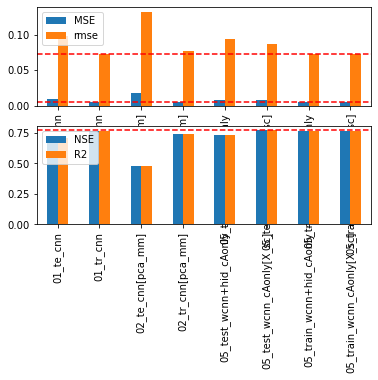

In [39]:
try:
    evaluation = pd.read_csv('testeva.csv',index_col=0)
    evaluation = evaluation.T.sort_index()

    droplist = evaluation.loc[(evaluation['MSE']>1)|(evaluation['R2']<0)].index
    evaluation = evaluation.drop(droplist)

    fig,ax = plt.subplots(2)
    evaluation[['MSE','rmse']].plot.bar(ax=ax[0])
    ax[0].axhline(np.min(evaluation['MSE']),color='r',ls='--')
    ax[0].axhline(np.min(evaluation['rmse']),color='r',ls='--')

    evaluation[['NSE','R2']].plot.bar(ax=ax[1])
    ax[1].axhline(np.max(evaluation['NSE']),color='r',ls='--')
    ax[1].legend(loc='upper left')
    ax[0].legend(loc='upper left')
except: pass

In [2]:
from DLtools.Trial_evaluation_rec import record_list_result
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import pywt
np.random.seed(42)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #ignore cuDNN log

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/song/anaconda3/envs/tf-gpu-c

In [4]:
from sklearn.metrics import r2_score
def forecast_accuracy(forecast, actual,title):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       #MSE

    nse = nashsutcliffe(actual,forecast)
    r2 = r2_score(actual, forecast)
    result = {'MSE':mse,'rmse':rmse,'R2':r2,'NSE':nse,'mape':mape,  'mae': mae,
            'mpe': mpe}
    result =  pd.Series(result,name=title)
    try: 
      eval = pd.read_csv('testeva.csv',index_col=0)
      pd.concat([eval,result],axis=1).to_csv('testeva.csv')
    except:
      eval = pd.DataFrame(result)
      eval.to_csv('testeva.csv')
    return result

def nashsutcliffe(Y_evaluation, Yhat_simulation):
    """
    Nash-Sutcliffe model efficinecy
        .. math::
         NSE = 1-\\frac{\\sum_{i=1}^{N}(e_{i}-s_{i})^2}{\\sum_{i=1}^{N}(e_{i}-\\bar{e})^2} 
    :evaluation: Observed data to compared with simulation data.
    :type: list
    :simulation: simulation data to compared with evaluation data
    :type: list
    :return: Nash-Sutcliff model efficiency
    :rtype: float
    """
    if len(Y_evaluation) == len(Yhat_simulation):
        s, e = np.array(Yhat_simulation), np.array(Y_evaluation)
        # s,e=simulation(Yhat),evaluation(Y)
        mean_observed = np.nanmean(e)
        # compute numerator and denominator
        numerator = np.nansum((e - s) ** 2)
        denominator = np.nansum((e - mean_observed)**2)
        # compute coefficient
        return 1 - (numerator / denominator)

In [5]:
############# Keras ###################
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [16]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 24*7,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)

In [17]:
#------------ DL PARAMETER ---------------------#
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]
my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)

In [18]:
#--------------------------- 2 Yr Edit -----------------------------------#
host_path = './CPY012/2Yr_flood/'
start_p = '2016-01-01'
split_date = '2017-05-10'
stop_p = '2018-01-01'


In [19]:
#-----------------------Baseline / Hybrid -----------------------------------#
save_path =host_path+'trial'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [9]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
def split_xy(data,n_past,n_future):
    x,y = split_series(data.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],n_features))
    y = y[:,:,0]
    return x,y

In [20]:
#------------------------- Main ---------------------------------#
df = df[start_p:stop_p]
data = df
data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

#------------------------
syn = ''
Yscale = False
allscale=True

data_mar.columns

Index(['CPY012_wl', 'WAN005_wl', 'YOM012_wl', 'DNP028_press', 'PIN004_wl',
       'CPY006_wl', 'BKK013_wl', 'BKK021_wl', 'WAN003_wl', 'NAN009_wl'],
      dtype='object')

In [21]:
def wavelet_t(series,std):
    name = series.name
    idx = series.index
    signal = series.values
    if std: signal = (signal - signal.mean())/(signal.std())

    coeff = pywt.swt(signal,'db4',level=3)
    coeff = np.array(coeff)

    cA3,cD3 = coeff[0][0],coeff[0][1]
    _,cD2 = coeff[1][0],coeff[1][1]
    _,cD1 = coeff[2][0],coeff[2][1]
    #----------------------------
    dict_data = {
            '{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
    wt = pd.DataFrame(dict_data,dtype='float32',index=idx)
    return wt
def df_wavelet(df,std):
    wav_df = pd.DataFrame()
    for col in df:
        a = wavelet_t(df[col],std)
        wav_df = pd.concat([wav_df,a],axis=1)
    return wav_df
    

In [22]:
##----------- SCALE
wdata = df_wavelet(data_mar,False)

if allscale:
    syn = syn+'[X_sc]'  
    scaler = MinMaxScaler()
    wdata[wdata.columns] = scaler.fit_transform(wdata[wdata.columns])

# Y data
if Yscale:
    syn = syn+'[y_sc]'        
    scaler_tar = MinMaxScaler()
    scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
    print(data_mar[target].to_numpy().reshape(-1,1).shape)
    
scaler_tar = MinMaxScaler()
scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
data_mar[target] = scaler_tar.transform(data_mar[target].to_numpy().reshape(-1,1))


/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:xlabel='date'>

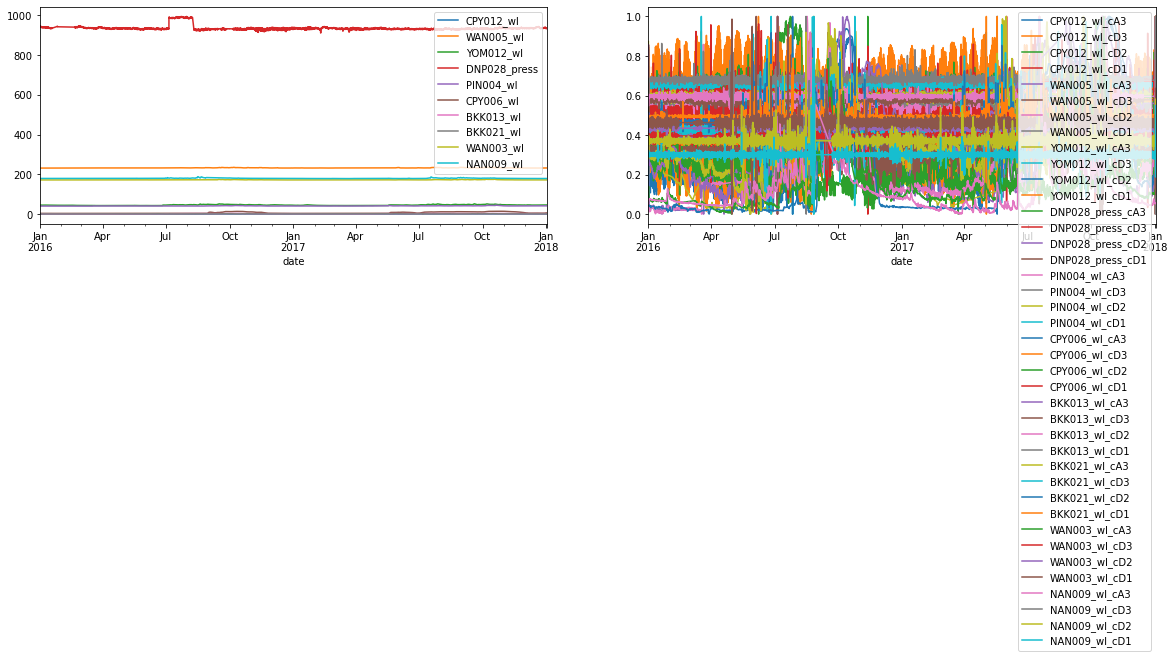

In [23]:
fig,ax = plt.subplots(1,2, figsize=(20,4))
data_mar.plot(ax=ax[0])
wdata.plot(ax=ax[1])

In [24]:
##--- train test split 
sc_train,sc_test = wdata[:split_date],wdata[split_date:]
train,test = data_mar[:split_date],data_mar[split_date:]

##--------- Keep original
n_features = len(data_mar.columns)
_, y_train = split_xy(train,n_past,n_future)
_, y_test = split_xy(test,n_past,n_future)
##--------- Wavelet_traintest
n_features=n_features*4
x_train,_= split_xy(sc_train,n_past,n_future)
x_test,_ = split_xy(sc_test,n_past,n_future)


# Deep learning

In [34]:
#----------------------------------------------------------#
def build_lstm():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model
#------------------------------------------------------------#
def build_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer='adam', loss='mse')    
    model.summary()
    return model

In [27]:
model = build_cnn1d()
verbose, epochs,batch = 1, 100,16

history = model.fit(x_train,y_train,epochs=epochs,validation_data=(x_test,y_test),batch_size=batch,verbose=verbose,callbacks=callbacks)
trainPred = model.predict(x_train)
testPred = model.predict(x_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168, 40)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 167, 64)           5184      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 83, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 5312)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5312)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               531300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0     

In [28]:
if Yscale:
    y_train = scaler_tar.inverse_transform(y_train)
    trainPred = scaler_tar.inverse_transform(trainPred.reshape(y_train.shape))
    y_test = scaler_tar.inverse_transform(y_test)
    testPred = scaler_tar.inverse_transform(testPred.reshape(y_test.shape))

forecast_accuracy(trainPred,y_train,'04_train_wcnn'+syn)
forecast_accuracy(testPred,y_test,'04_test_wcnn'+syn)

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


MSE     0.010630
rmse    0.103103
R2      0.681426
NSE     0.681497
mape    0.156237
mae     0.086989
mpe    -0.099281
Name: 04_test_wcnn[X_sc], dtype: float64

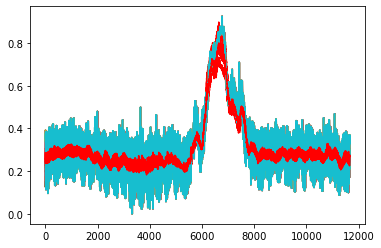

In [29]:
for i in range(5):
    plt.title(syn)
    plt.plot(y_train[:,i],alpha=0.1)
    plt.plot(trainPred[:,i],color='red')

LSTM

In [35]:
model = build_lstm()
verbose, epochs,batch = 1, 100,16

history = model.fit(x_train,y_train,epochs=epochs,validation_data=(x_test,y_test),batch_size=batch,verbose=verbose,callbacks=callbacks)
trainPred = model.predict(x_train)
testPred = model.predict(x_test)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 168, 40)]         0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               193600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 72)                7272      
Total params: 220,972
Trainable params: 220,972
Non-trainable params: 0
_____________________________________________________

11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1448 - val_loss: 0.3584
Epoch 66/100
11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1448 - val_loss: 0.3584
Epoch 67/100
11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1448 - val_loss: 0.3584
Epoch 68/100
11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1450 - val_loss: 0.3584
Epoch 69/100
11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1448 - val_loss: 0.3584
Epoch 70/100
11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1449 - val_loss: 0.3584
Epoch 71/100
11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1449 - val_loss: 0.3584
Epoch 72/100
11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1448 - val_loss: 0.3584
Epoch 73/100
11665/11665 [==============================] - 16s 1ms/sample - loss: 0.1448 - val_loss: 0.3584
Epoch 74/100
11665/11665 [======

In [36]:
if Yscale:
    y_train = scaler_tar.inverse_transform(y_train)
    trainPred = scaler_tar.inverse_transform(trainPred.reshape(y_train.shape))
    y_test = scaler_tar.inverse_transform(y_test)
    testPred = scaler_tar.inverse_transform(testPred.reshape(y_test.shape))

forecast_accuracy(trainPred,y_train,'04_train_lstm_v2'+syn)
forecast_accuracy(testPred,y_test,'04_test_lstm_v2'+syn)

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


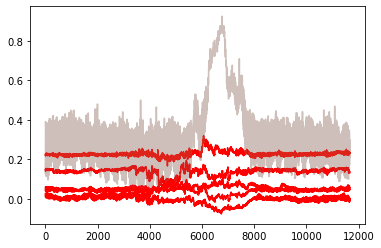

In [37]:
for i in range(5):
    plt.title(syn)
    plt.plot(y_train[:,i],alpha=0.1)
    plt.plot(trainPred[:,i],color='red')